By [Yulandy Chiu](https://www.youtube.com/@YulandySpace)

Aided with Gemini/Claude/ChatGPT and modified by Yulandy Chiu

Version: 2025/02

Videos:
* [大型語言模型 LLM 這樣理解語言！Python 預處理全解析：Tokenization & Embedding](https://youtu.be/2JFoO-xnm2E)

YouTube: [Yulandy Chiu的AI觀測站](https://www.youtube.com/@YulandySpace)

Facebook: [Yulandy Chiu的AI資訊站](https://www.facebook.com/yulandychiu)

 This code is licensed under the Creative Commons Attribution-NonCommercial 4.0
 International License (CC BY-NC 4.0). You are free to use, modify, and share this code for non-commercial purposes, provided you give appropriate credit. For more details, see the LICENSE file or visit: https://creativecommons.org/licenses/by-nc/4.0/
 © [2025] Yulandy Chiu


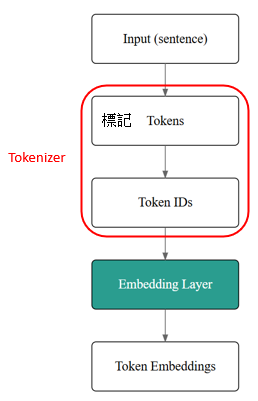

安裝必要套件 (使用Google Colab不須執行)

In [ ]:
!pip install transformers torch matplotlib seaborn

* 加載tokenizers
* 顯示tokenizers資訊

In [ ]:
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

def load_tokenizers():
    """Load different tokenizers"""
    tokenizers = {
        'bert': AutoTokenizer.from_pretrained('bert-base-uncased'),     # Google AI
        'gpt2': AutoTokenizer.from_pretrained('gpt2', use_fast=False),           # OpenAI
        'roberta': AutoTokenizer.from_pretrained('roberta-base'),      # Meta AI
        't5': AutoTokenizer.from_pretrained('t5-small')           # Google Research
    }
    return tokenizers

#### bert 擅長的語言任務
## 文本分類（Text Classification）
#   情感分析（Sentiment Analysis）
#   垃圾郵件分類（Spam Detection）
#   文章主題分類（Topic Classification）
#   問答系統（Question Answering, QA）
## 問答（Question Answering)
#### gpt2 擅長的語言任務
## 文本生成（Text Generation）
## 對話系統（Chatbots)
## 自動補全（Text Completion）
## 摘要（Summarization)

# 選擇合適的 Tokenizer 會影響模型的效果，選擇錯誤可能會導致 Token 分割不合理，影響模型表現


def get_vocab_info(tokenizers):
    """Get vocabulary information for each tokenizer"""
    vocab_info = {}
    for name, tokenizer in tokenizers.items():
        vocab_size = tokenizer.vocab_size
        special_tokens = []

        # Collect common special tokens if they exist
        special_token_attrs = [
            'pad_token', 'eos_token', 'bos_token', 'unk_token',
            'cls_token', 'sep_token', 'mask_token'
        ]

        for attr in special_token_attrs:
            if hasattr(tokenizer, attr):
                token = getattr(tokenizer, attr)
                if token is not None:
                    special_tokens.append(f"{attr}: {token}")

        # Get some example tokens
        sample_tokens = list(tokenizer.get_vocab().items())[:5]

        vocab_info[name] = {
            'vocab_size': vocab_size,
            'special_tokens': special_tokens,
            'sample_tokens': sample_tokens
        }

    return vocab_info

def display_vocab_info(vocab_info):
    """Display vocabulary information in a formatted way"""
    print("\n=== Tokenizer Vocabulary Information ===")
    for name, info in vocab_info.items():
        print(f"\n{name.upper()} Tokenizer:")
        print(f"Vocabulary Size: {info['vocab_size']} tokens")

        print("Special Tokens:")
        for token in info['special_tokens']:
            print(f"  - {token}")

        print("Sample Vocabulary Tokens (first 5):")
        for token, id in info['sample_tokens']:
            print(f"  - '{token}': {id}")
        print("-" * 50)

# Load tokenizers
print("Loading tokenizers...")
tokenizers = load_tokenizers()

# Get vocabulary information
vocab_info = get_vocab_info(tokenizers)
display_vocab_info(vocab_info)

Loading tokenizers...


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]


=== Tokenizer Vocabulary Information ===

BERT Tokenizer:
Vocabulary Size: 30522 tokens
Special Tokens:
  - pad_token: [PAD]
  - unk_token: [UNK]
  - cls_token: [CLS]
  - sep_token: [SEP]
  - mask_token: [MASK]
Sample Vocabulary Tokens (first 5):
  - 'prisoners': 5895
  - 'spend': 5247
  - 'cleavage': 28691
  - 'hamburg': 8719
  - 'essex': 8862
--------------------------------------------------

GPT2 Tokenizer:
Vocabulary Size: 50257 tokens
Special Tokens:
  - eos_token: <|endoftext|>
  - bos_token: <|endoftext|>
  - unk_token: <|endoftext|>
Sample Vocabulary Tokens (first 5):
  - '!': 0
  - '"': 1
  - '#': 2
  - '$': 3
  - '%': 4
--------------------------------------------------

ROBERTA Tokenizer:
Vocabulary Size: 50265 tokens
Special Tokens:
  - pad_token: <pad>
  - eos_token: </s>
  - bos_token: <s>
  - unk_token: <unk>
  - cls_token: <s>
  - sep_token: </s>
  - mask_token: <mask>
Sample Vocabulary Tokens (first 5):
  - 'Ġbuzz': 8775
  - 'Ġoverthrow': 23850
  - 'ĠKot': 15542
  - 

分析tokens和token IDs

In [ ]:

def analyze_tokenization(sentence, tokenizers):
    """Analyze tokenization for each tokenizer"""
    results = {}

    for name, tokenizer in tokenizers.items():
        # Tokenize the sentence
        tokens = tokenizer(sentence, return_tensors='pt')

        # Get token IDs and decode them back to tokens
        token_ids = tokens['input_ids'][0].tolist()
        decoded_tokens = tokenizer.convert_ids_to_tokens(token_ids)

        # Remove special tokens if present
        if tokenizer.bos_token_id in token_ids:
            token_ids = [id for id in token_ids if id != tokenizer.bos_token_id]
            decoded_tokens = [token for token in decoded_tokens if token != tokenizer.bos_token]
        if tokenizer.eos_token_id in token_ids:
            token_ids = [id for id in token_ids if id != tokenizer.eos_token_id]
            decoded_tokens = [token for token in decoded_tokens if token != tokenizer.eos_token]

        results[name] = {
            'token_ids': token_ids,
            'tokens': decoded_tokens
        }

    return results

# Example usage
# sentence = "Youtube Channel Yulandy CHIU is awesome!"
sentence = "The feeling of unhappiness is overwhelming."
# Analyze tokenization
print("Analyzing tokenization...")
results = analyze_tokenization(sentence, tokenizers)
# Print text results
for name, data in results.items():
    print(f"\n{name.upper()} Tokenizer:")
    print(f"Token IDs: {data['token_ids']}")
    print(f"Tokens: {data['tokens']}")

#### 以下的設計有助於模型學習連續詞語的結構，減少詞彙表大小
## BERT
# 子詞（subword）前加上 ## 來表示這是某個詞的一部分，而不是一個獨立單詞
## GPT2
# 'ĠChannel'：代表這個單詞 前面有空格
# 'Y' + 'outube'：因為 "YouTube" 不在詞彙表裡，所以拆成 'Y' 和 'outube'
# 'ĠCH' + 'IU'："Chiu" 被拆成兩個 token，可能因為它的詞頻較低

Analyzing tokenization...

BERT Tokenizer:
Token IDs: [101, 1996, 3110, 1997, 4895, 3270, 9397, 9961, 2003, 10827, 1012, 102]
Tokens: ['[CLS]', 'the', 'feeling', 'of', 'un', '##ha', '##pp', '##iness', 'is', 'overwhelming', '.', '[SEP]']

GPT2 Tokenizer:
Token IDs: [464, 4203, 286, 14274, 42661, 318, 9721, 13]
Tokens: ['The', 'Ġfeeling', 'Ġof', 'Ġunh', 'appiness', 'Ġis', 'Ġoverwhelming', '.']

ROBERTA Tokenizer:
Token IDs: [133, 2157, 9, 24376, 37055, 16, 8642, 4]
Tokens: ['The', 'Ġfeeling', 'Ġof', 'Ġunh', 'appiness', 'Ġis', 'Ġoverwhelming', '.']

T5 Tokenizer:
Token IDs: [37, 1829, 13, 73, 107, 3096, 6096, 19, 11316, 5]
Tokens: ['▁The', '▁feeling', '▁of', '▁un', 'h', 'app', 'iness', '▁is', '▁overwhelming', '.']


圖示化Tokenization

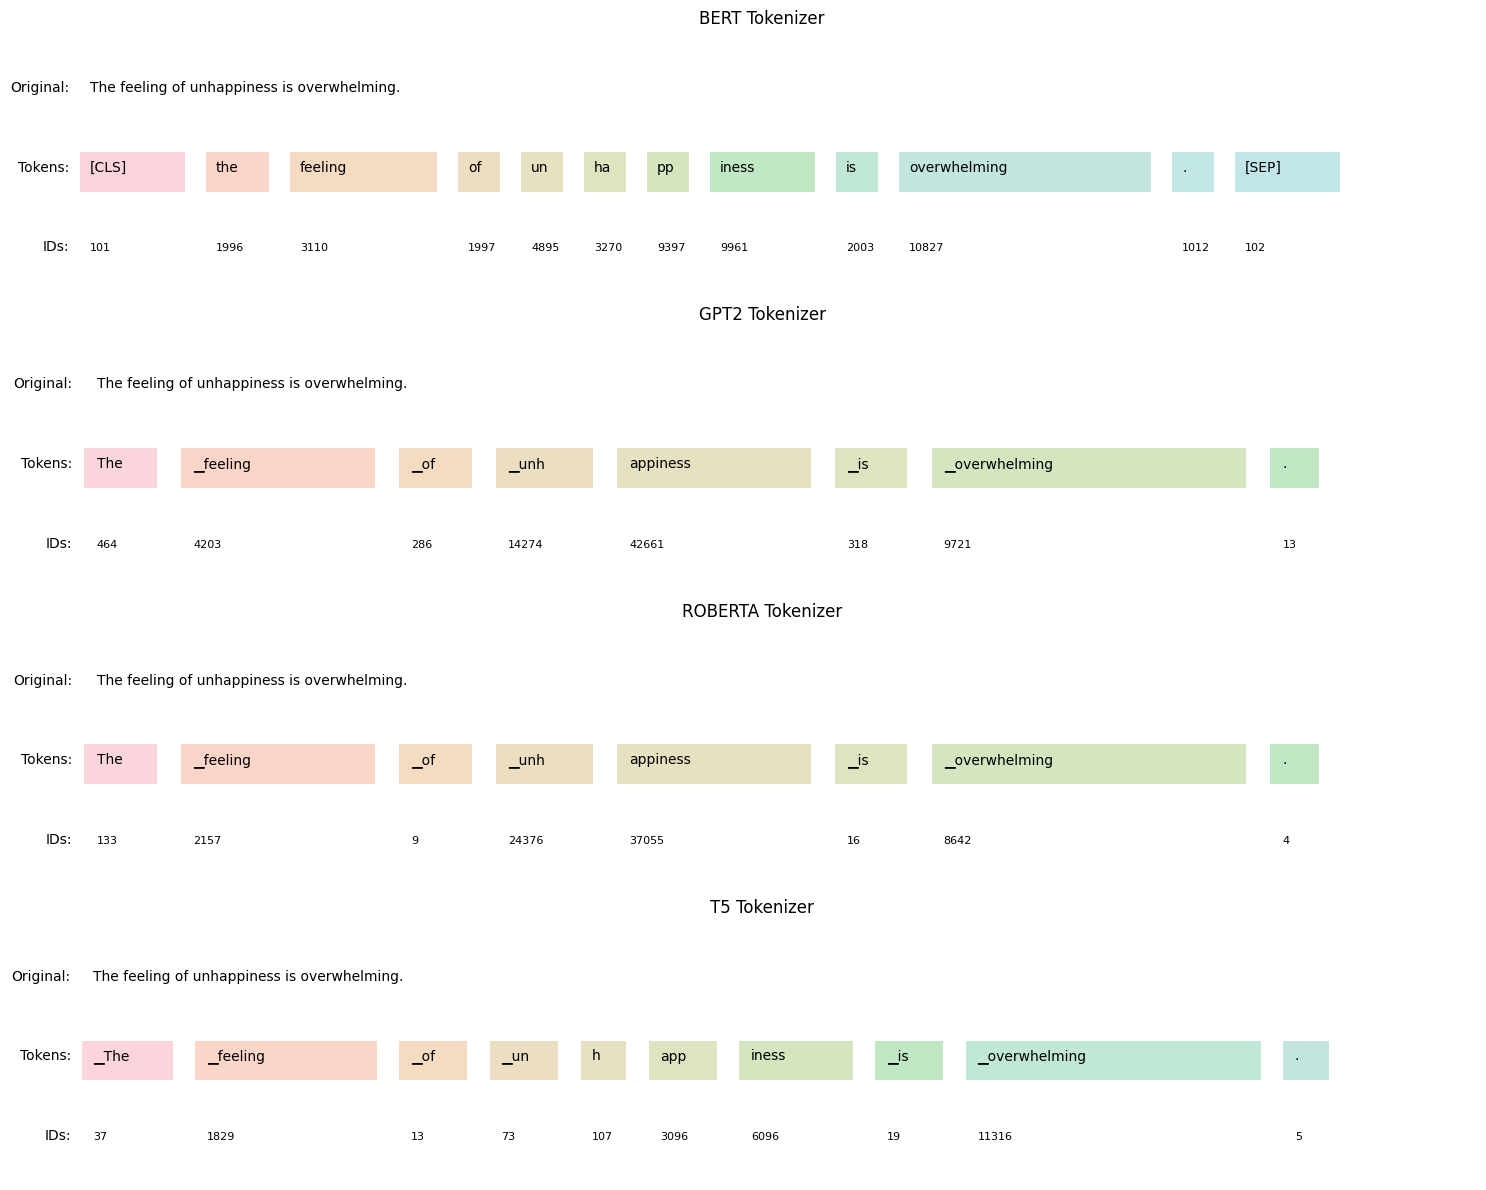

In [ ]:
def visualize_tokenization(sentence, results):
    """Create a visual representation of tokenization"""
    num_tokenizers = len(results)
    fig, axes = plt.subplots(num_tokenizers, 1, figsize=(15, 3*num_tokenizers))
    if num_tokenizers == 1:
        axes = [axes]

    # Color palette
    colors = sns.color_palette("husl", 20)

    for idx, (name, data) in enumerate(results.items()):
        ax = axes[idx]
        tokens = data['tokens']

        # Plot original sentence
        ax.text(-0.1, 0.7, 'Original:', fontsize=10, ha='right')
        ax.text(0, 0.7, sentence, fontsize=10)

        # Plot tokenization
        ax.text(-0.1, 0.3, 'Tokens:', fontsize=10, ha='right')

        current_pos = 0
        for i, token in enumerate(tokens):
            # Add token text
            token_display = token.replace('Ġ', '▁').replace('##', '')  # Replace special chars
            ax.text(current_pos, 0.3, token_display, fontsize=10)

            # Add colored rectangle
            width = max(len(token_display) * 0.1, 0.2)
            rect = Rectangle((current_pos-0.05, 0.2), width, 0.2,
                           facecolor=colors[i % len(colors)], alpha=0.3)
            ax.add_patch(rect)

            current_pos += width + 0.1

        # Add token IDs
        ax.text(-0.1, -0.1, 'IDs:', fontsize=10, ha='right')
        current_pos = 0
        for i, token_id in enumerate(data['token_ids']):
            width = max(len(tokens[i].replace('Ġ', '▁').replace('##', '')) * 0.1, 0.2)
            ax.text(current_pos, -0.1, str(token_id), fontsize=8)
            current_pos += width + 0.1

        ax.set_title(f'{name.upper()} Tokenizer')
        ax.set_ylim(-0.3, 1)
        ax.set_xlim(-0.2, current_pos + 0.5)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
# Visualize results
visualize_tokenization(sentence, results)

產生embeddings

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

def get_embeddings(text, model_name='bert-base-uncased'):
    """
    將文本轉換為 embeddings
    Args:
        text: 輸入文本
        model_name: 使用的模型名稱
    Returns:
        token_embeddings: token 的 embeddings
        tokens: 分詞後的結果
    """
    # 載入 tokenizer 和模型
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # 將文本轉換為 tokens
    inputs = tokenizer(text, return_tensors="pt", padding=True)

    # 獲取 token IDs
    token_ids = inputs['input_ids']

    # 獲取原始的 tokens（用於展示）
    tokens = tokenizer.convert_ids_to_tokens(token_ids[0])

    # 通過模型獲取 embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        # 獲取最後一層的 hidden states
        token_embeddings = outputs.last_hidden_state

    # 取得詞彙表大小
    vocab_size = tokenizer.vocab_size

    return token_embeddings, tokens, vocab_size


text = "YouTube Channel Yulandy CHIU is awesome!"
token_embeddings, tokens, vocab_size = get_embeddings(text)




print(f"文本: {text}")
print(f"\nTokens: {tokens}")
print(f"Vocabulary Size: {vocab_size} tokens")
print(f"\nEmbedding 形狀: {token_embeddings.shape}")
# 1：表示這是一個單獨的輸入樣本（batch size 為 1）。
# 12：表示句子總共有 12 個 token。
# 768：表示每個 token 都會被映射到一個 768 維的向量，這是 BERT 預設的 embedding 維度。

print(f"每個 token 的 embedding 維度: {token_embeddings.shape[-1]}")
# 這是 Transformer 的隱藏層輸出，它用來捕捉語意資訊，而不是詞彙表的機率分佈。
# 這裡的維度是 hidden_dim = 768，而不是 vocab_size = 30522。
# 如果要將這個輸出轉換成詞彙表維度（如預測下一個詞），模型還需要經過一個 線性層（Linear Layer），將 768 維轉換成 30522 維。


# 展示第一個 token 的部分 embedding 值
print(f"\n第一個 token '{tokens[0]}' 的前五個 embedding 值:")
print(token_embeddings[0][0][:5].numpy())



文本: YouTube Channel Yulandy CHIU is awesome!

Tokens: ['[CLS]', 'youtube', 'channel', 'yu', '##land', '##y', 'chi', '##u', 'is', 'awesome', '!', '[SEP]']
Vocabulary Size: 30522 tokens

Embedding 形狀: torch.Size([1, 12, 768])
每個 token 的 embedding 維度: 768

第一個 token '[CLS]' 的前五個 embedding 值:
[ 0.08741701 -0.40386972 -0.06961852 -0.21829873 -0.43727538]
